<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Customer Churn😁😊🙁😠</h1></center>
<center><h3 style="padding-bottom: 25px; color:#0b0265; font-weight: bold; font-style:italic; font-family: Cursive">
(With Oversampling Techniques)</h3></center>     

</div>

In [2]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


# Import Libraries

In [3]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#-------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#-------------------------------------
from scipy.stats import shapiro

#-------------------------------------
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#-------------------------------------
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score,recall_score, precision_score
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, auc

#-------------------------------------
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from statsmodels.stats.outliers_influence import variance_inflation_factor

#-------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

#------------------------------------- 
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler

import warnings
warnings.filterwarnings("ignore")

# Define Functions

In [4]:
def outlier_detect(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    return df[((df[col] < (q1_col - 1.5 * iqr_col)) |(df[col] > (q3_col + 1.5 * iqr_col)))]

# ----------------------------------------------
def outlier_detect_normal(df, col):
    m = df[col].mean()
    s = df[col].std()
    return df[((df[col]-m)/s).abs()>3]

# ----------------------------------------------
def lower_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    lower = df[(df[col] < (q1_col - 1.5 * iqr_col))]
    return lower

# ----------------------------------------------
def upper_outlier(df, col):
    q1_col = Q1[col]
    iqr_col = IQR[col]
    q3_col = Q3[col]
    upper = df[(df[col] > (q3_col + 1.5 * iqr_col))]
    return upper

# ----------------------------------------------
def preprocess(df, col):
    print("************************* {} *************************\n".format(col))
    print("lower outlier: {} ****** upper outlier: {}\n".format(lower_outlier(df,col).shape[0], upper_outlier(df,col).shape[0]))
    plt.figure(figsize=(8,5))
    df[col].plot(kind='box', subplots=True, sharex=False, vert=False)
    plt.show()
    

# ----------------------------------------------
CV = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)
def RandomSearch_Tune(model, Data, X, y, params):
    
    clf = RandomizedSearchCV(model, params, scoring ='accuracy', cv = CV, n_jobs=-1)
    clf.fit(X, y)
    
    print("best score is :" , clf.best_score_)
    print("best estimator is :" , clf.best_estimator_)
    print("best Params is :" , clf.best_params_)
    
    return (clf.best_score_)

# ----------------------------------------------
def checkVIF(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False,)
    return(vif)


# Data Understanding

In [5]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.shape

(7043, 21)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [8]:
columns = df.columns
print("******************* Numeric field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes!=object:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))
        
print("\n******************* Categorical field *******************\n")
for i in range(len(columns)):
    if df[columns[i]].dtypes==object:
        print("unique number of {} -> {}".format(columns[i], len(df[columns[i]].unique())))

******************* Numeric field *******************

unique number of SeniorCitizen -> 2
unique number of tenure -> 73
unique number of MonthlyCharges -> 1585

******************* Categorical field *******************

unique number of customerID -> 7043
unique number of gender -> 2
unique number of Partner -> 2
unique number of Dependents -> 2
unique number of PhoneService -> 2
unique number of MultipleLines -> 3
unique number of InternetService -> 3
unique number of OnlineSecurity -> 3
unique number of OnlineBackup -> 3
unique number of DeviceProtection -> 3
unique number of TechSupport -> 3
unique number of StreamingTV -> 3
unique number of StreamingMovies -> 3
unique number of Contract -> 3
unique number of PaperlessBilling -> 2
unique number of PaymentMethod -> 4
unique number of TotalCharges -> 6531
unique number of Churn -> 2


In [9]:
df.drop(['customerID'], axis=1, inplace=True)

In [10]:
df.TotalCharges.value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

In [11]:
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan, regex=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.00,0.000,0.0000,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


In [13]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

No     5174
Yes    1869
Name: Churn, dtype: int64

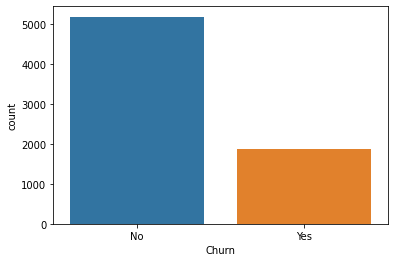

In [14]:
sns.countplot(x = "Churn", data = df)
df.loc[:, 'Churn'].value_counts()

<div style="padding: 10px; font-family: Cursive; border: solid 2px #0b0265;
            font-size:15.5px;padding: 25px 10px; border-radius:8px;">
<p>This dataset is an imbalanced dataset. This point is well illustrated in the plot above.</p>

<p style="padding-left:30px; font-style:italic; color:#0b0265"> Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance. <br>
The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.<br>
ref : <a href="https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification">machinelearningmastery.com</a></p>

<p>One approach to addressing imbalanced datasets is to oversample the minority class that these techniques create new examples synthesized from the existing examples. In the following, we use five oversampling methods. :</p>  
<ul>
  <li>RandomOverSampler</li>
  <li>SMOTE</li>
  <li>BorderlineSMOTE</li>  
  <li>SVMSMOTE</li>
  <li>ADASYN</li>

</ul> 
<br>
Refer to the references in the <b>references section</b> for more details on how each method works.😊😉
</div>

In [15]:
categorical_feature = df.dtypes==object
final_categorical_feature = df.columns[categorical_feature].tolist()

#------------------------------------------------------
numeric_feature = df.dtypes!=object
final_numeric_feature = df.columns[numeric_feature].tolist()

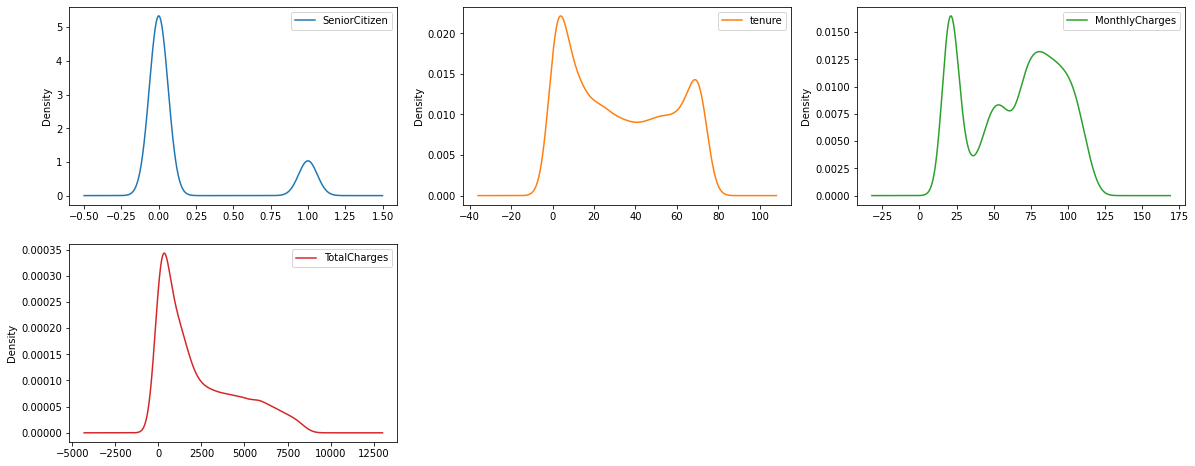

In [16]:
df[final_numeric_feature].plot(kind='density', subplots=True, layout=(2,3), sharex=False, figsize= (20,8))
plt.show()

# Preprocessing

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
1. Numerical Field</h3>
</div>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Manage Missing Data</h3></center>
</div>

In [17]:
print("Mode: {}".format(df.TotalCharges.mode()))
print("Mean: {}".format(df.TotalCharges.mean()))
print("Median: {}".format(df.TotalCharges.median()))

Mode: 0    20.2
dtype: float64
Mean: 2283.3004408418697
Median: 1397.475


In [18]:
df['TotalCharges'] = df['TotalCharges'].fillna(df.TotalCharges.median())

In [19]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Manage Outlier</h3></center>
</div>

In [20]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

In [21]:
for i in range(len(final_numeric_feature)):
    stat,p = shapiro(df[final_numeric_feature[i]])
    print(final_numeric_feature[i])
    print('P_value=%.3f' % (p))
    print("*******************************")

SeniorCitizen
P_value=0.000
*******************************
tenure
P_value=0.000
*******************************
MonthlyCharges
P_value=0.000
*******************************
TotalCharges
P_value=0.000
*******************************


<div style="padding: 10px; font-family: Cursive; border: solid 2px #0b0265;
            font-size:15.5px;padding: 25px 10px; border-radius:8px;">
<p style="padding-left:30px; font-style:italic">
<b>In Shapiro-Wilk Normality Test : </b> 
<br>
H0 : The data are normally distributed
<br><br>
According to the P_value obtained from the Shapiro test (p_value &lt 5%), we reject our null hypothesis (H0) --> So the numerical fields do not follow the normal distribution.
</p>

</div>

************************* SeniorCitizen *************************

lower outlier: 0 ****** upper outlier: 1142



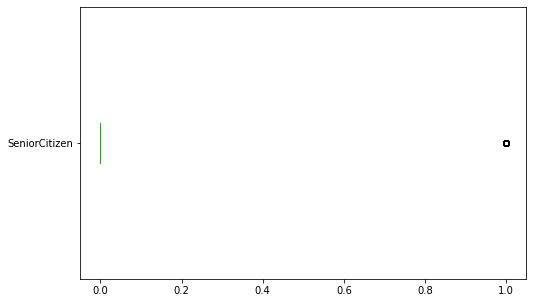

************************* tenure *************************

lower outlier: 0 ****** upper outlier: 0



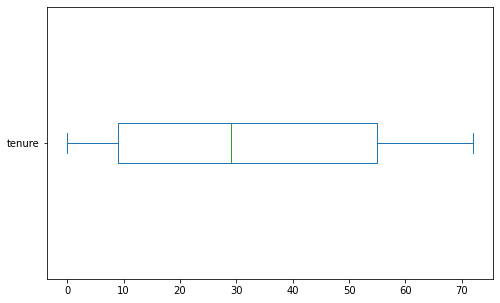

************************* MonthlyCharges *************************

lower outlier: 0 ****** upper outlier: 0



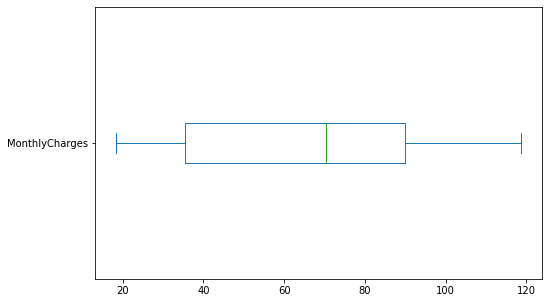

************************* TotalCharges *************************

lower outlier: 0 ****** upper outlier: 0



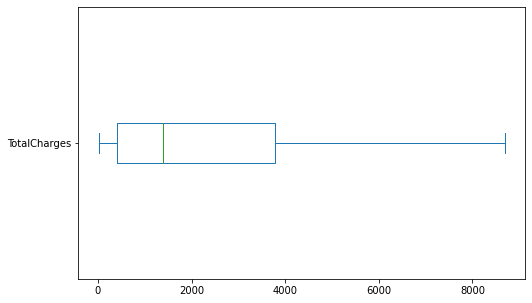

In [22]:
for i in range(len(final_numeric_feature)):
    preprocess(df[final_numeric_feature], final_numeric_feature[i])

In [23]:
for i in range(len(final_numeric_feature)):
    print("IQR => {}: {}".format(final_numeric_feature[i],(outlier_detect(df[final_numeric_feature],final_numeric_feature[i]).shape[0])))
    print("********************************")

IQR => SeniorCitizen: 1142
********************************
IQR => tenure: 0
********************************
IQR => MonthlyCharges: 0
********************************
IQR => TotalCharges: 0
********************************


<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#f0f5ff;padding: 25px 10px">
✔ SeniorCitizen is a binary field so 1142 instance is not outlier data</div>
<!-- <p style="padding: 5px 0px; font-style: italic; font-family: Cursive; font-size:15px">
In this case, we don't have any outlier data</p> -->

<div style="border-radius:10px;
            background-color:#ffffff;
            letter-spacing:0.5px;">

<h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
2. Categorical field</h3>
</div>

In [24]:
for i in range(len(final_categorical_feature)):
    print("\n************ {} ************".format(final_categorical_feature[i]))
    print(df[final_categorical_feature[i]].unique())


************ gender ************
['Female' 'Male']

************ Partner ************
['Yes' 'No']

************ Dependents ************
['No' 'Yes']

************ PhoneService ************
['No' 'Yes']

************ MultipleLines ************
['No phone service' 'No' 'Yes']

************ InternetService ************
['DSL' 'Fiber optic' 'No']

************ OnlineSecurity ************
['No' 'Yes' 'No internet service']

************ OnlineBackup ************
['Yes' 'No' 'No internet service']

************ DeviceProtection ************
['No' 'Yes' 'No internet service']

************ TechSupport ************
['No' 'Yes' 'No internet service']

************ StreamingTV ************
['No' 'Yes' 'No internet service']

************ StreamingMovies ************
['No' 'Yes' 'No internet service']

************ Contract ************
['Month-to-month' 'One year' 'Two year']

************ PaperlessBilling ************
['Yes' 'No']

************ PaymentMethod ************
['Electronic check' '

In [25]:
df_dummy = pd.get_dummies(df, prefix=['Contract', 'PaymentMethod'],columns=['Contract', 'PaymentMethod'], drop_first=True)
df_dummy.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,Yes,29.85,29.85,No,0,0,0,1,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,56.95,1889.50,No,1,0,0,0,1
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,Yes,53.85,108.15,Yes,0,0,0,0,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,42.30,1840.75,No,1,0,0,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,Yes,70.70,151.65,Yes,0,0,0,1,0


In [26]:
final_categorical_feature.remove('Contract')
final_categorical_feature.remove('PaymentMethod')

In [27]:
le = LabelEncoder() 
df_dummy[final_categorical_feature] = df_dummy[final_categorical_feature].apply(lambda col: le.fit_transform(col)) 
df_dummy.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,0,0,2,...,0,1,29.85,29.85,0,0,0,0,1,0
1,1,0,0,0,34,1,0,0,2,0,...,0,0,56.95,1889.50,0,1,0,0,0,1
2,1,0,0,0,2,1,0,0,2,2,...,0,1,53.85,108.15,1,0,0,0,0,1
3,1,0,0,0,45,0,1,0,2,0,...,0,0,42.30,1840.75,0,1,0,0,0,0
4,0,0,0,0,2,1,0,1,0,0,...,0,1,70.70,151.65,1,0,0,0,1,0


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Manage Duplicate Data</h3></center>
</div>

In [28]:
df_dummy.loc[df.duplicated()].shape

(22, 23)

In [29]:
df_dummy = df_dummy.drop_duplicates()
df_dummy.shape

(7021, 23)

<AxesSubplot:>

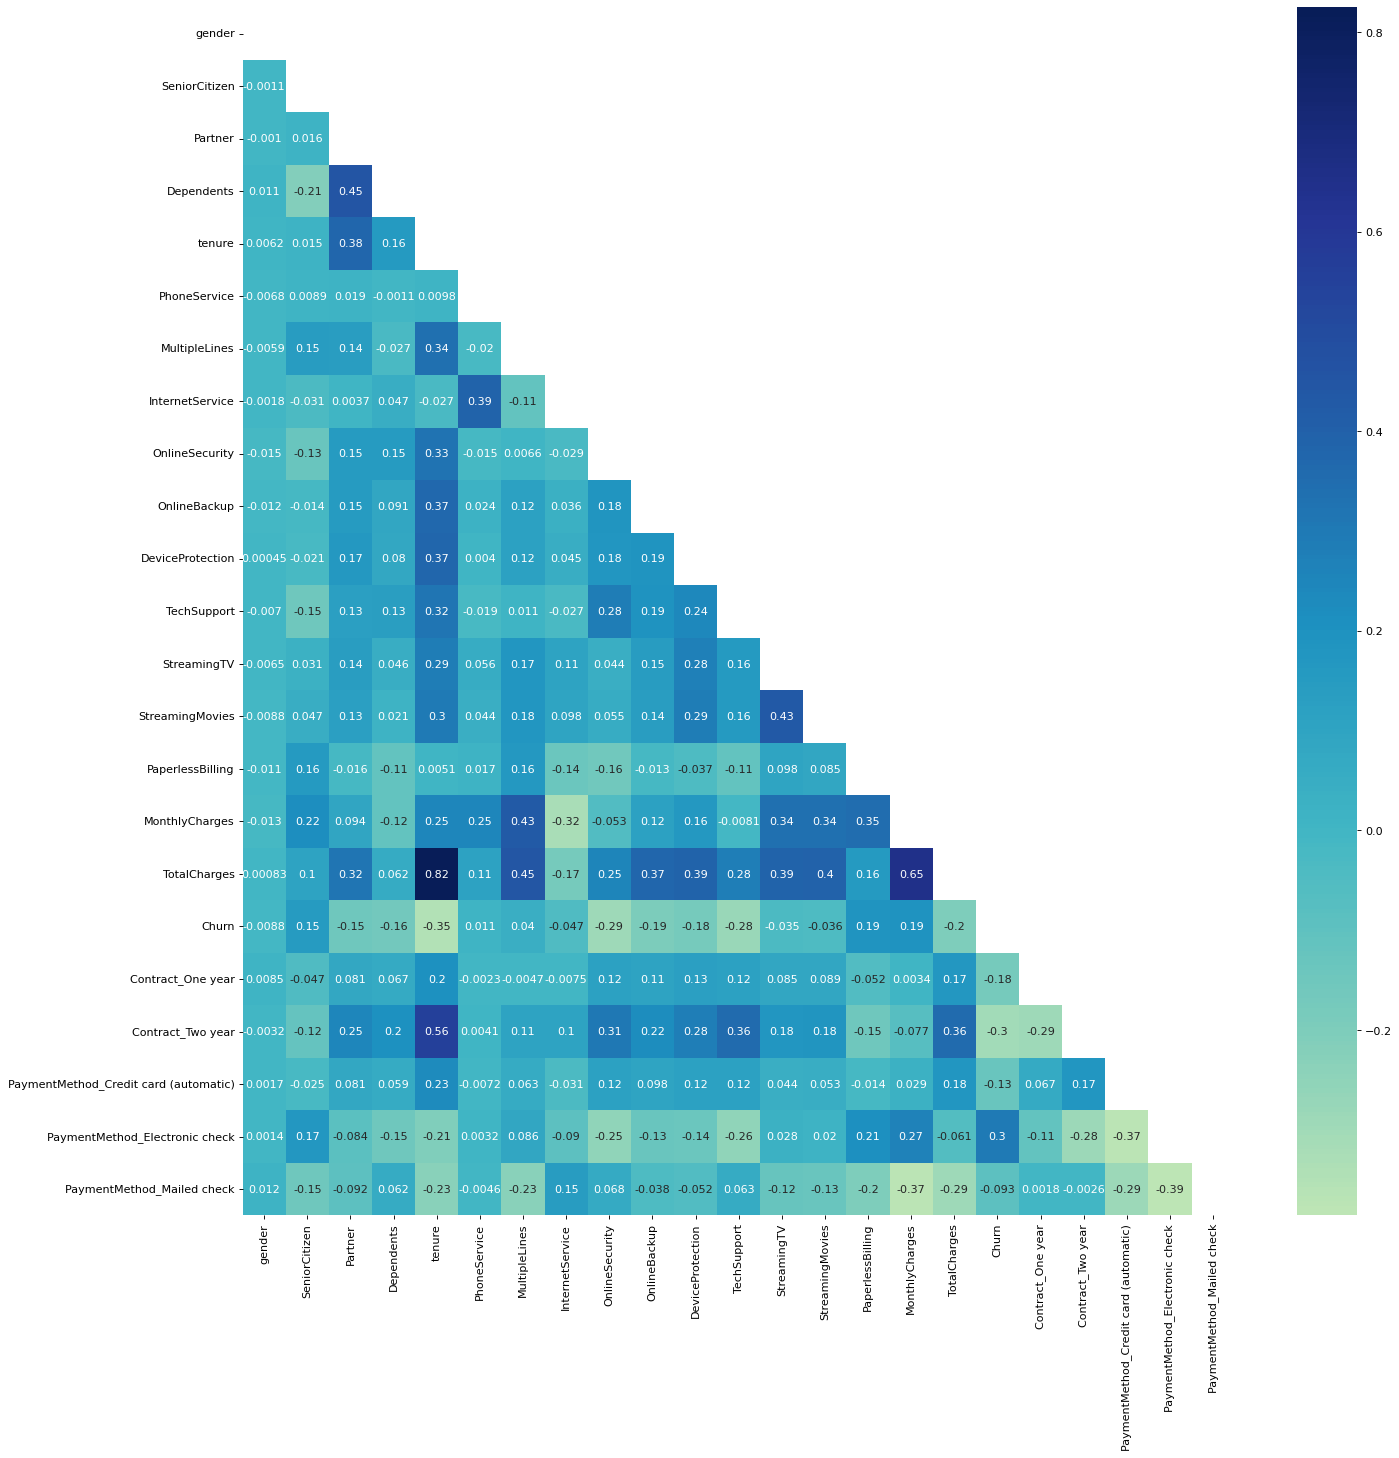

In [30]:
mask = np.triu(np.ones_like(df_dummy.corr()))
fig, ax = plt.subplots(figsize=(20,20),dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(df_dummy.corr(), mask= mask, cmap="YlGnBu", annot = True, center = 0,annot_kws={"fontsize":10})

# Balancing Data

In [31]:
x = df_dummy.drop("Churn", axis = 1)
y = df_dummy['Churn']

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state =100 ,stratify=y, test_size = 0.2)
print(y_train.value_counts())

0    4131
1    1485
Name: Churn, dtype: int64


In [33]:
scale = MinMaxScaler()
col = x_train.columns

x_train[col] = scale.fit_transform(x_train[col])
x_test[col] = scale.transform(x_test[col])

<div style="border-radius:10px;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><b><h2 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
1. RandomOverSampler</h2></b></center>
</div>

In [34]:
x_train_randOverSample = x_train.copy()
y_train_randOverSample = y_train.copy()

In [35]:
print("Before OverSampling- counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y==0)))
print("*******************************************************************")

randOverSample = RandomOverSampler(random_state=100,)
x_train_randOverSample, y_train_randOverSample = randOverSample.fit_resample(x_train_randOverSample, y_train_randOverSample.ravel())

print('After OverSampling with RandomOverSampler- x_train: {}'.format(x_train_randOverSample.shape))
print('After OverSampling with RandomOverSampler- y_train: {} \n'.format(y_train_randOverSample.shape))

print("After OverSampling with RandomOverSampler- counts of label '1': {}".format(sum(y_train_randOverSample==1)))
print("After OverSampling with RandomOverSampler- counts of label '0': {}".format(sum(y_train_randOverSample==0)))

Before OverSampling- counts of label '1': 1857
Before OverSampling- counts of label '0': 5164 

*******************************************************************
After OverSampling with RandomOverSampler- x_train: (8262, 22)
After OverSampling with RandomOverSampler- y_train: (8262,) 

After OverSampling with RandomOverSampler- counts of label '1': 4131
After OverSampling with RandomOverSampler- counts of label '0': 4131


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Feature Selection</h3></center>
</div>

In [36]:
sfs_randOverSample = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 9,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = CV,
          n_jobs= -1).fit(x_train_randOverSample, y_train_randOverSample)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   17.5s finished

[2022-07-15 12:08:43] Features: 1/9 -- score: 0.6844585435264426[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   19.3s finished

[2022-07-15 12:09:03] Features: 2/9 -- score: 0.7265753869846671[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   27.1s finished

[2022-07-15 12:09:30] Features: 3/9 -- score: 0.7541719977397225[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   38.2s finished

[2022-07-15 12:10:08] Features: 4/9 -- score: 0.761797652473569[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   37.7s finished

[2022

In [37]:
print("Feature Names: ",sfs_randOverSample.k_feature_names_)
print("*****************************************")
print("Score: ", sfs_randOverSample.k_score_)

Feature Names:  ('tenure', 'InternetService', 'OnlineBackup', 'TechSupport', 'MonthlyCharges', 'TotalCharges', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check')
*****************************************
Score:  0.7809208580856153


In [38]:
x_train_new_randOverSample = x_train_randOverSample[['tenure',
                                                     'InternetService',
                                                     'OnlineBackup',
                                                     'TechSupport',
                                                     'MonthlyCharges',
                                                     'Contract_One year',
                                                     'Contract_Two year',
                                                     'PaymentMethod_Electronic check']]

x_test_new_randOverSample = x_test[['tenure',
                                     'InternetService',
                                     'OnlineBackup',
                                     'TechSupport',
                                     'MonthlyCharges',
                                     'Contract_One year',
                                     'Contract_Two year',
                                     'PaymentMethod_Electronic check']]

<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#f0f5ff;padding: 25px 10px">
We deleted TotalCharges because the value obtained for its VIF is greater than 10 (The threshold for VIF = 10)</div>

In [39]:
checkVIF(x_train_new_randOverSample).reset_index(drop=True)

,Features,VIF
0,tenure,5.40
1,MonthlyCharges,3.88
2,Contract_Two year,2.63
3,OnlineBackup,2.15
4,TechSupport,1.97
5,PaymentMethod_Electronic check,1.96
6,InternetService,1.90
7,Contract_One year,1.78


<div style="padding: 5px 0px; font-family: Cursive; font-size:16px; background-color:#f0f5ff;padding: 25px 10px">
The hyperparameter of each model has been tuned with the help of random search</div>

In [40]:
DT = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=3, random_state=0)
cross_val_DT = cross_val_score(DT, x_train_new_randOverSample, y_train_randOverSample , cv = CV, scoring = 'accuracy' ) 
cross_val_DT_f1 = cross_val_score(DT, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=2,min_samples_split=6, n_estimators=25, random_state=0)
cross_val_RF = cross_val_score(RF, x_train_new_randOverSample, y_train_randOverSample , cv = CV, scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
ET = ExtraTreesClassifier(max_depth=4, max_features='log2', min_samples_leaf=2,min_samples_split=6, 
                          n_estimators=25, random_state=0)
cross_val_ET = cross_val_score(ET, x_train_new_randOverSample, y_train_randOverSample , cv = CV, scoring = 'accuracy') 
cross_val_ET_f1 = cross_val_score(ET, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
MLP = MLPClassifier(activation='tanh', hidden_layer_sizes=20, learning_rate_init=0.025, max_iter=100, random_state=0)
cross_val_MLP = cross_val_score(MLP, x_train_new_randOverSample, y_train_randOverSample , cv = CV, scoring = 'accuracy') 
cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
cross_val_GB = cross_val_score(GB, x_train_new_randOverSample, y_train_randOverSample , cv = CV, scoring = 'accuracy') 
cross_val_GB_f1 = cross_val_score(GB, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
LR = LogisticRegression(C=10, random_state=0, solver='newton-cg')
cross_val_LR = cross_val_score(LR, x_train_new_randOverSample, y_train_randOverSample ,cv = CV, scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, x_train_new_randOverSample, y_train_randOverSample ,cv = CV, 
                               scoring = 'f1') 

# --------------------------------------------------------------------------
XGB = XGBClassifier(learning_rate_init= 0.2, max_depth= 5, n_estimators= 300, n_jobs=-1, random_state = 0,
                    min_child_weight= 1, colsample_bytree= 0.8, gamma= 0.5)
cross_val_XGB = cross_val_score(XGB, x_train_new_randOverSample, y_train_randOverSample ,cv = CV, scoring = 'accuracy') 
cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_randOverSample, y_train_randOverSample ,cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
KNN = KNeighborsClassifier(n_neighbors=19)
cross_val_KNN = cross_val_score(KNN, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
LGBM = LGBMClassifier(boosting_type='goss', learning_rate=0.2, max_depth=3,min_child_samples=15, 
                      n_estimators=300, num_leaves=20, random_state=0, reg_alpha=0)
cross_val_LGBM = cross_val_score(LGBM, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                 scoring = 'accuracy') 
cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                    scoring = 'f1') 

# --------------------------------------------------------------------------
estimators = [('DT', DT),
              ('RF', RF),
              ('MLP', MLP),
              ('ET', ET),
              ('LR', LR),
              ('KNN', KNN),
              ('GB', GB),
              ('LGBM', LGBM)
             ]
SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                    scoring = 'accuracy' ) 
cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_randOverSample, y_train_randOverSample , cv = CV, 
                                    scoring = 'f1' ) 

[12:14:22] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:14:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:14:23] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:14:23]

In [41]:
compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
                  ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
                  ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
                  ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
                  ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
                  ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
                  ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
                  ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), ''),
                  ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
                  ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), 'The Best Model')]

In [42]:
predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Cross_validation_mean(accuracy),Cross_validation_mean(f1_score),Description
0,Decision Tree,0.811061,0.816981,
1,Random Forest,0.846887,0.856031,
2,Neural Network,0.765791,0.772138,
3,Extra Tree,0.753448,0.774150,
4,GradientBoosting,0.783826,0.792224,
5,Logistic Regression,0.749456,0.758997,
6,KNN,0.763008,0.775010,
7,XGBC,0.831393,0.841483,
8,LGBM,0.778623,0.787482,
9,Stacking,0.871821,0.878257,The Best Model


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Best Model</h3></center>
</div>

In [43]:
SC_tune.fit(x_train_new_randOverSample, y_train_randOverSample)
y_test_pred_SC_tune = SC_tune.predict(x_test_new_randOverSample)
test_acc_SC_tune = accuracy_score(y_test, y_test_pred_SC_tune)

print("Test set Accuracy: ", test_acc_SC_tune)

Test set Accuracy:  0.7800711743772242


<div style="border-radius:10px;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><b><h2 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
2. SMOTE</h2></b></center>
</div>

In [44]:
x_train_smote = x_train.copy()
y_train_smote = y_train.copy()

In [45]:
print("Before OverSampling- counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y==0)))
print("*******************************************************************")

sm = SMOTE(random_state=100)
x_train_smote, y_train_smote = sm.fit_resample(x_train_smote, y_train_smote.ravel())

print('After OverSampling with SMOTE- x_train: {}'.format(x_train_smote.shape))
print('After OverSampling with SMOTE- y_train: {} \n'.format(y_train_smote.shape))

print("After OverSampling with SMOTE- counts of label '1': {}".format(sum(y_train_smote==1)))
print("After OverSampling with SMOTE- counts of label '0': {}".format(sum(y_train_smote==0)))

Before OverSampling- counts of label '1': 1857
Before OverSampling- counts of label '0': 5164 

*******************************************************************
After OverSampling with SMOTE- x_train: (8262, 22)
After OverSampling with SMOTE- y_train: (8262,) 

After OverSampling with SMOTE- counts of label '1': 4131
After OverSampling with SMOTE- counts of label '0': 4131


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Feature Selection</h3></center>
</div>

In [46]:
sfs = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 9,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = CV,
          n_jobs= -1).fit(x_train_smote, y_train_smote)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   20.4s finished

[2022-07-15 12:22:16] Features: 1/9 -- score: 0.7246440502296875[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   31.2s finished

[2022-07-15 12:22:47] Features: 2/9 -- score: 0.7900010540153592[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.4s finished

[2022-07-15 12:23:18] Features: 3/9 -- score: 0.8027096978196522[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   32.3s finished

[2022-07-15 12:23:51] Features: 4/9 -- score: 0.8117890154032633[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   32.1s finished

[202

In [47]:
print("Feature Names: ",sfs.k_feature_names_)
print("*****************************************")
print("Score: ", sfs.k_score_)

Feature Names:  ('SeniorCitizen', 'tenure', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Electronic check')
*****************************************
Score:  0.8306684799634608


In [48]:
x_train_new_smote = x_train_smote[['SeniorCitizen',
                                     'tenure',
                                     'InternetService',
                                     'OnlineSecurity',
                                     'OnlineBackup',
                                     'TechSupport',
                                     'Contract_One year',
                                     'Contract_Two year',
                                     'PaymentMethod_Electronic check']]

x_test_new_smote = x_test[['SeniorCitizen',
                             'tenure',
                             'InternetService',
                             'OnlineSecurity',
                             'OnlineBackup',
                             'TechSupport',
                             'Contract_One year',
                             'Contract_Two year',
                             'PaymentMethod_Electronic check']]

In [49]:
checkVIF(x_train_new_smote).reset_index(drop=True)

,Features,VIF
0,tenure,4.65
1,Contract_Two year,2.65
2,OnlineBackup,2.20
3,TechSupport,2.08
4,OnlineSecurity,1.97
5,InternetService,1.95
6,Contract_One year,1.82
7,PaymentMethod_Electronic check,1.53
8,SeniorCitizen,1.32


In [50]:
DT = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4, min_samples_split=5, random_state=0)
cross_val_DT = cross_val_score(DT, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy' ) 
cross_val_DT_f1 = cross_val_score(DT, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1' ) 

# --------------------------------------------------------------------------
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=3,min_samples_split=5, 
                            n_estimators=200, random_state=0)
cross_val_RF = cross_val_score(RF, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
ET = ExtraTreesClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, min_samples_split=3, 
                          n_estimators=75, random_state=0)
cross_val_ET = cross_val_score(ET, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_ET_f1 = cross_val_score(ET, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
MLP = MLPClassifier(activation='tanh', hidden_layer_sizes=20, learning_rate_init=0.01, max_iter=100, random_state=0)
cross_val_MLP = cross_val_score(MLP, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
cross_val_GB = cross_val_score(GB, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_GB_f1 = cross_val_score(GB, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LR = LogisticRegression(C=4, multi_class='ovr', penalty='l1', random_state=0, solver='saga')
cross_val_LR = cross_val_score(LR, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
XGB = XGBClassifier(learning_rate_init= 0.001, max_depth= 5, n_estimators= 300, n_jobs=-1, random_state = 0,
                    min_child_weight= 2, colsample_bytree= 0.6, gamma= 1.5)
cross_val_XGB = cross_val_score(XGB, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
KNN = KNeighborsClassifier(n_neighbors=17)
cross_val_KNN = cross_val_score(KNN, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LGBM = LGBMClassifier(boosting_type='goss', learning_rate=0.2, max_depth=6,min_child_samples=10, 
                      n_estimators=75, num_leaves=60, random_state=0, reg_alpha=0.01)
cross_val_LGBM = cross_val_score(LGBM, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy') 
cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_smote, y_train_smote , cv = CV, scoring = 'accuracy' ) 
cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_smote, y_train_smote , cv = CV, scoring = 'f1' ) 


[12:28:11] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:28:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:28:12] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:28:12]

In [51]:
compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
                  ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
                  ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
                  ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
                  ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
                  ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
                  ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
                  ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), 'The Best Model'),
                  ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
                  ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), '')]


In [52]:
predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Cross_validation_mean(accuracy),Cross_validation_mean(f1_score),Description
0,Decision Tree,0.773058,0.775906,
1,Random Forest,0.825101,0.828471,
2,Neural Network,0.788551,0.798350,
3,Extra Tree,0.771121,0.781739,
4,GradientBoosting,0.836720,0.841041,
5,Logistic Regression,0.750544,0.767426,
6,KNN,0.779473,0.777865,
7,XGBC,0.841441,0.842109,The Best Model
8,LGBM,0.829458,0.833428,
9,Stacking,0.836358,0.837001,


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Best Model</h3></center>
</div>

In [53]:
XGB.fit(x_train_new_smote, y_train_smote)
y_test_pred_XGB = XGB.predict(x_test_new_smote)
test_acc_XGB = accuracy_score(y_test, y_test_pred_XGB)

[12:36:06] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:36:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [54]:
print("Test set Accuracy: ", test_acc_XGB)

Test set Accuracy:  0.7900355871886121


<div style="border-radius:10px;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><b><h2 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
3. BorderlineSMOTE</h2></b></center>
</div>

In [55]:
x_train_borderlineSmote = x_train.copy()
y_train_borderlineSmote = y_train.copy()

In [56]:
print("Before OverSampling- counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y==0)))
print("*******************************************************************")

bsm = BorderlineSMOTE(random_state=100)
x_train_borderlineSmote, y_train_borderlineSmote = bsm.fit_resample(x_train_borderlineSmote, y_train_borderlineSmote.ravel())
print('After OverSampling with BorderlineSMOTE- x_train: {}'.format(x_train_borderlineSmote.shape))
print('After OverSampling with BorderlineSMOTE- y_train: {} \n'.format(y_train_borderlineSmote.shape))

print("After OverSampling with BorderlineSMOTE- counts of label '1': {}".format(sum(y_train_borderlineSmote==1)))
print("After OverSampling with BorderlineSMOTE- counts of label '0': {}".format(sum(y_train_borderlineSmote==0)))


Before OverSampling- counts of label '1': 1857
Before OverSampling- counts of label '0': 5164 

*******************************************************************
After OverSampling with BorderlineSMOTE- x_train: (8262, 22)
After OverSampling with BorderlineSMOTE- y_train: (8262,) 

After OverSampling with BorderlineSMOTE- counts of label '1': 4131
After OverSampling with BorderlineSMOTE- counts of label '0': 4131


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Feature Selection</h3></center>
</div>

In [57]:
sfs_borderlineSmote = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 9,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = CV,
          n_jobs= -1).fit(x_train_borderlineSmote, y_train_borderlineSmote)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   20.1s finished

[2022-07-15 12:36:28] Features: 1/9 -- score: 0.7199238181120827[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   29.9s finished

[2022-07-15 12:36:58] Features: 2/9 -- score: 0.7752364946962533[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.7s finished

[2022-07-15 12:37:29] Features: 3/9 -- score: 0.7884285216556238[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   32.8s finished

[2022-07-15 12:38:02] Features: 4/9 -- score: 0.7977490916437077[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   33.2s finished

[202

In [58]:
print("Feature Names: ",sfs_borderlineSmote.k_feature_names_)
print("*****************************************")
print("Score: ", sfs_borderlineSmote.k_score_)

Feature Names:  ('gender', 'Partner', 'tenure', 'InternetService', 'OnlineSecurity', 'TechSupport', 'PaperlessBilling', 'Contract_One year', 'PaymentMethod_Electronic check')
*****************************************
Score:  0.8254639863446455


In [59]:
x_train_new_borderlineSmote = x_train_borderlineSmote[['gender', 
                                                       'Partner', 
                                                       'tenure', 
                                                       'InternetService', 
                                                       'OnlineSecurity', 
                                                       'TechSupport', 
                                                       'PaperlessBilling', 
                                                       'Contract_One year', 
                                                       'PaymentMethod_Electronic check']]

x_test_new_borderlineSmote = x_test[['gender', 
                                   'Partner', 
                                   'tenure', 
                                   'InternetService', 
                                   'OnlineSecurity', 
                                   'TechSupport', 
                                   'PaperlessBilling', 
                                   'Contract_One year', 
                                   'PaymentMethod_Electronic check']]

In [60]:
checkVIF(x_train_new_borderlineSmote).reset_index(drop=True)

,Features,VIF
0,tenure,3.45
1,PaperlessBilling,2.28
2,Partner,2.16
3,InternetService,1.99
4,TechSupport,1.94
5,OnlineSecurity,1.88
6,gender,1.77
7,PaymentMethod_Electronic check,1.57
8,Contract_One year,1.35


In [61]:
DT = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, random_state=0)
cross_val_DT = cross_val_score(DT, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                               scoring = 'accuracy' ) 
cross_val_DT_f1 = cross_val_score(DT, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                  scoring = 'f1' ) 
# --------------------------------------------------------------------------
RF = RandomForestClassifier(criterion='entropy', min_samples_leaf=6,min_samples_split=5, 
                            n_estimators=200, random_state=0)
cross_val_RF = cross_val_score(RF, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                               scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
ET = ExtraTreesClassifier(max_depth=5, min_samples_leaf=4, n_estimators=75, random_state=0)
cross_val_ET = cross_val_score(ET, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                               scoring = 'accuracy') 
cross_val_ET_f1 = cross_val_score(ET, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
MLP = MLPClassifier(activation='tanh', hidden_layer_sizes=10, learning_rate_init=0.025, random_state=0)
cross_val_MLP = cross_val_score(MLP, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                scoring = 'accuracy') 
cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
cross_val_GB = cross_val_score(GB, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                               scoring = 'accuracy') 
cross_val_GB_f1 = cross_val_score(GB, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
LR = LogisticRegression(C=9, penalty='none', random_state=0)
cross_val_LR = cross_val_score(LR, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                               scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                  scoring = 'f1') 

# --------------------------------------------------------------------------
XGB = XGBClassifier(learning_rate_init= 0.001, max_depth= 6, n_estimators= 300, n_jobs=-1, random_state = 0,
                    min_child_weight= 2, colsample_bytree= 0.8, gamma= 2)
cross_val_XGB = cross_val_score(XGB, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                scoring = 'accuracy') 
cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
KNN = KNeighborsClassifier(n_neighbors=20)
cross_val_KNN = cross_val_score(KNN, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                   scoring = 'f1') 

# --------------------------------------------------------------------------
LGBM = LGBMClassifier(boosting_type='dart', learning_rate=0.2, max_depth=3, min_child_samples=10, 
                      num_leaves=5, random_state=0, reg_alpha=0.01)
cross_val_LGBM = cross_val_score(LGBM, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                 scoring = 'accuracy')
cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                 scoring = 'f1')

# --------------------------------------------------------------------------
SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                    scoring = 'accuracy' ) 
cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_borderlineSmote, y_train_borderlineSmote , cv = CV, 
                                    scoring = 'f1' )

[12:42:28] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:42:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:42:30] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:42:30]

In [62]:
compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
                  ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
                  ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
                  ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
                  ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
                  ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
                  ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
                  ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), 'The Best Model'),
                  ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
                  ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), '')]

In [63]:
predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Cross_validation_mean(accuracy),Cross_validation_mean(f1_score),Description
0,Decision Tree,0.760108,0.766455,
1,Random Forest,0.822196,0.827504,
2,Neural Network,0.770876,0.782587,
3,Extra Tree,0.752483,0.762252,
4,GradientBoosting,0.830669,0.834614,
5,Logistic Regression,0.716171,0.719133,
6,KNN,0.757081,0.763985,
7,XGBC,0.841320,0.843344,The Best Model
8,LGBM,0.809850,0.818299,
9,Stacking,0.835267,0.839215,


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Best Model</h3></center>
</div>

In [64]:
XGB.fit(x_train_new_borderlineSmote, y_train_borderlineSmote)
y_test_pred_XGB = XGB.predict(x_test_new_borderlineSmote)
test_acc_XGB = accuracy_score(y_test, y_test_pred_XGB)

[12:50:15] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:50:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [65]:
print("Test set Accuracy: ", test_acc_XGB)

Test set Accuracy:  0.7829181494661922


<div style="border-radius:10px;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><b><h2 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
4. SVMSMOTE</h2></b></center>
</div>

In [66]:
x_train_SVMSmote = x_train.copy()
y_train_SVMSmote = y_train.copy()

In [67]:
print("Before OverSampling- counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y==0)))
print("*******************************************************************")

SVMsm = SVMSMOTE(random_state=100)
x_train_SVMSmote, y_train_SVMSmote = SVMsm.fit_resample(x_train_SVMSmote, y_train_SVMSmote.ravel())
print('After OverSampling with SVMSMOTE- x_train: {}'.format(x_train_SVMSmote.shape))
print('After OverSampling with SVMSMOTE- y_train: {} \n'.format(y_train_SVMSmote.shape))

print("After OverSampling with SVMSMOTE- counts of label '1': {}".format(sum(y_train_SVMSmote==1)))
print("After OverSampling with SVMSMOTE- counts of label '0': {}".format(sum(y_train_SVMSmote==0)))


Before OverSampling- counts of label '1': 1857
Before OverSampling- counts of label '0': 5164 

*******************************************************************
After OverSampling with SVMSMOTE- x_train: (8262, 22)
After OverSampling with SVMSMOTE- y_train: (8262,) 

After OverSampling with SVMSMOTE- counts of label '1': 4131
After OverSampling with SVMSMOTE- counts of label '0': 4131


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Feature Selection</h3></center>
</div>

In [68]:
sfs_SVMSmote = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 9,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = CV,
          n_jobs= -1).fit(x_train_SVMSmote, y_train_SVMSmote)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   20.6s finished

[2022-07-15 12:50:39] Features: 1/9 -- score: 0.7288778249807496[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   30.3s finished

[2022-07-15 12:51:09] Features: 2/9 -- score: 0.7942390741060632[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.1s finished

[2022-07-15 12:51:41] Features: 3/9 -- score: 0.8028325198872205[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   30.9s finished

[2022-07-15 12:52:12] Features: 4/9 -- score: 0.8148152106127636[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   31.6s finished

[202

In [69]:
print("Feature Names: ",sfs_SVMSmote.k_feature_names_)
print("*****************************************")
print("Score: ", sfs_SVMSmote.k_score_)

Feature Names:  ('gender', 'Partner', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'StreamingTV', 'PaperlessBilling', 'Contract_One year')
*****************************************
Score:  0.8237708277826739


In [70]:
x_train_new_SVMSmote = x_train_SVMSmote[['gender', 
                                         'Partner', 
                                         'tenure', 
                                         'PhoneService', 
                                         'MultipleLines', 
                                         'InternetService', 
                                         'StreamingTV', 
                                         'PaperlessBilling', 
                                         'Contract_One year']]

x_test_new_SVMSmote = x_test[['gender', 
                             'Partner', 
                             'tenure', 
                             'PhoneService', 
                             'MultipleLines', 
                             'InternetService', 
                             'StreamingTV', 
                             'PaperlessBilling', 
                             'Contract_One year']]

In [71]:
checkVIF(x_train_new_SVMSmote).reset_index(drop=True)

,Features,VIF
0,PhoneService,6.70
1,tenure,3.38
2,InternetService,3.24
3,PaperlessBilling,2.79
4,StreamingTV,2.32
5,MultipleLines,2.31
6,Partner,2.05
7,gender,1.88
8,Contract_One year,1.29


In [72]:
DT = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, random_state=0)
cross_val_DT = cross_val_score(DT, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_DT_f1 = cross_val_score(DT, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
RF = RandomForestClassifier(min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0)
cross_val_RF = cross_val_score(RF, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
ET = ExtraTreesClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4, random_state=0)
cross_val_ET = cross_val_score(ET, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_ET_f1 = cross_val_score(ET, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=10, learning_rate_init=0.2, max_iter=50, random_state=0)
cross_val_MLP = cross_val_score(MLP, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
cross_val_GB = cross_val_score(GB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_GB_f1 = cross_val_score(GB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LR = LogisticRegression(C=6, penalty='none', random_state=0)
cross_val_LR = cross_val_score(LR, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
XGB = XGBClassifier(learning_rate_init= 0.025, max_depth= 6, n_estimators= 300, n_jobs=-1, random_state = 0,
                    min_child_weight= 1, colsample_bytree= 0.6, gamma= 0.5)
cross_val_XGB = cross_val_score(XGB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
KNN = KNeighborsClassifier(n_neighbors=13)
cross_val_KNN = cross_val_score(KNN, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LGBM = LGBMClassifier(boosting_type='dart', learning_rate=0.2, max_depth=6, min_child_samples=10, 
                      n_estimators=200, num_leaves=40, random_state=0, reg_alpha=0.01)
cross_val_LGBM = cross_val_score(LGBM, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, 
                                    scoring = 'accuracy') 
cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, 
                                       scoring = 'f1') 


[12:55:41] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:55:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:55:42] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[12:55:42]

In [73]:
compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
                  ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
                  ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
                  ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
                  ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
                  ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
                  ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
                  ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), 'The Best Model'),
                  ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
                  ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), '')]

In [74]:
predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Cross_validation_mean(accuracy),Cross_validation_mean(f1_score),Description
0,Decision Tree,0.790972,0.788048,
1,Random Forest,0.814571,0.818756,
2,Neural Network,0.788668,0.791552,
3,Extra Tree,0.782378,0.795598,
4,GradientBoosting,0.824739,0.831377,
5,Logistic Regression,0.745460,0.757372,
6,KNN,0.786248,0.785710,
7,XGBC,0.841441,0.842224,The Best Model
8,LGBM,0.833333,0.838168,
9,Stacking,0.829096,0.835179,


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Best Model</h3></center>
</div>

In [75]:
XGB.fit(x_train_new_SVMSmote, y_train_SVMSmote)
y_test_pred_XGB = XGB.predict(x_test_new_SVMSmote)
test_acc_XGB = accuracy_score(y_test, y_test_pred_XGB)

[13:03:09] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:03:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [76]:
print("Test set Accuracy: ", test_acc_XGB)

Test set Accuracy:  0.7907473309608541


<div style="border-radius:10px;
           background-color:#e8efff;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><b><h2 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
5. ADASYN</h2></b></center>
</div>

In [77]:
x_train_adasyn = x_train.copy()
y_train_adasyn = y_train.copy()

In [78]:
print("Before OverSampling- counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling- counts of label '0': {} \n".format(sum(y==0)))
print("*******************************************************************")

adasyn = ADASYN(random_state=100)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train_adasyn, y_train_adasyn.ravel())
print('After OverSampling with ADASYN- x_train: {}'.format(x_train_adasyn.shape))
print('After OverSampling with ADASYN- y_train: {} \n'.format(y_train_adasyn.shape))

print("After OverSampling with ADASYN- counts of label '1': {}".format(sum(y_train_adasyn==1)))
print("After OverSampling with ADASYN- counts of label '0': {}".format(sum(y_train_adasyn==0)))


Before OverSampling- counts of label '1': 1857
Before OverSampling- counts of label '0': 5164 

*******************************************************************
After OverSampling with ADASYN- x_train: (8142, 22)
After OverSampling with ADASYN- y_train: (8142,) 

After OverSampling with ADASYN- counts of label '1': 4011
After OverSampling with ADASYN- counts of label '0': 4131


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Feature Selection</h3></center>
</div>

In [79]:
sfs_adasyn = SFS(GradientBoostingClassifier(n_estimators=100, random_state=0),
          k_features = 9,
          forward= True,
          floating = False,
          verbose= 2,
          scoring= 'accuracy',
          cv = CV,
          n_jobs= -1).fit(x_train_adasyn, y_train_adasyn)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   20.5s finished

[2022-07-15 13:03:31] Features: 1/9 -- score: 0.7118620460951749[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   30.7s finished

[2022-07-15 13:04:02] Features: 2/9 -- score: 0.7716775448063792[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   31.5s finished

[2022-07-15 13:04:34] Features: 3/9 -- score: 0.7878902940866132[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   32.1s finished

[2022-07-15 13:05:06] Features: 4/9 -- score: 0.7961189912723656[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   32.7s finished

[202

In [80]:
print("Feature Names: ",sfs_adasyn.k_feature_names_)
print("*****************************************")
print("Score: ", sfs_adasyn.k_score_)

Feature Names:  ('gender', 'Partner', 'Dependents', 'tenure', 'InternetService', 'OnlineBackup', 'TechSupport', 'Contract_One year', 'PaymentMethod_Credit card (automatic)')
*****************************************
Score:  0.8203136823382222


In [81]:
x_train_new_adasyn = x_train_adasyn[['gender', 
                                     'Partner', 
                                     'Dependents', 
                                     'tenure', 
                                     'InternetService', 
                                     'OnlineBackup', 
                                     'TechSupport', 
                                     'Contract_One year', 
                                     'PaymentMethod_Credit card (automatic)']]

x_test_new_adasyn = x_test[['gender', 
                             'Partner', 
                             'Dependents', 
                             'tenure', 
                             'InternetService', 
                             'OnlineBackup', 
                             'TechSupport', 
                             'Contract_One year', 
                             'PaymentMethod_Credit card (automatic)']]

In [82]:
checkVIF(x_train_new_adasyn).reset_index(drop=True)

,Features,VIF
0,tenure,3.69
1,Partner,2.69
2,OnlineBackup,2.25
3,InternetService,1.92
4,TechSupport,1.89
5,Dependents,1.77
6,gender,1.66
7,Contract_One year,1.34
8,PaymentMethod_Credit card (automatic),1.31


In [83]:
DT = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=5, random_state=0)
cross_val_DT = cross_val_score(DT, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_DT_f1 = cross_val_score(DT, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
RF = RandomForestClassifier(min_samples_leaf=2, min_samples_split=4, random_state=0)
cross_val_RF = cross_val_score(RF, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_RF_f1 = cross_val_score(RF, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
ET = ExtraTreesClassifier(criterion='entropy', max_depth=5, max_features='sqrt', min_samples_leaf=6, 
                          n_estimators=200, random_state=0)
cross_val_ET = cross_val_score(ET, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_ET_f1 = cross_val_score(ET, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
MLP = MLPClassifier(activation='tanh', hidden_layer_sizes=(20, 30), learning_rate_init=0.1, random_state=0, solver='sgd')
cross_val_MLP = cross_val_score(MLP, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
cross_val_GB = cross_val_score(GB, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_GB_f1 = cross_val_score(GB, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LR = LogisticRegression(C=4, multi_class='ovr', penalty='l1', random_state=0, solver='saga')
cross_val_LR = cross_val_score(LR, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_LR_f1 = cross_val_score(LR, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
XGB = XGBClassifier(learning_rate_init= 0.0001, max_depth= 4, n_estimators= 200, n_jobs=-1, 
                    random_state = 0, min_child_weight= 1, colsample_bytree= 1.0, gamma= 0.5)
cross_val_XGB = cross_val_score(XGB, x_train_new_adasyn, y_train_adasyn ,cv = CV, scoring = 'accuracy') 
cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_adasyn, y_train_adasyn ,cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
KNN = KNeighborsClassifier(n_neighbors=18)
cross_val_KNN = cross_val_score(KNN, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
LGBM = LGBMClassifier(boosting_type='goss', min_child_samples=5, n_estimators=200, num_leaves=10, 
                      random_state=0, reg_alpha=0)
cross_val_LGBM = cross_val_score(LGBM, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'accuracy') 
cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_adasyn, y_train_adasyn , cv = CV, scoring = 'f1') 

# --------------------------------------------------------------------------
SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_adasyn, y_train_adasyn , cv = CV, 
                                    scoring = 'accuracy') 
cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_adasyn, y_train_adasyn , cv = CV, 
                                       scoring = 'f1') 


[13:11:00] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:11:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:11:01] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:11:01]

In [84]:
compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
                  ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
                  ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
                  ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
                  ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
                  ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
                  ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
                  ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), 'The Best Model'),
                  ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
                  ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), '')]

In [85]:
predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
predict.style.background_gradient(cmap='YlGn')

,Model,Cross_validation_mean(accuracy),Cross_validation_mean(f1_score),Description
0,Decision Tree,0.781135,0.775972,
1,Random Forest,0.807173,0.806695,
2,Neural Network,0.771557,0.774436,
3,Extra Tree,0.743921,0.739159,
4,GradientBoosting,0.825103,0.824837,
5,Logistic Regression,0.704740,0.709186,
6,KNN,0.728441,0.717556,
7,XGBC,0.837630,0.834652,The Best Model
8,LGBM,0.826454,0.826606,
9,Stacking,0.826578,0.825657,


<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Best Model</h3></center>
</div>

In [86]:
XGB.fit(x_train_new_adasyn, y_train_adasyn)
y_test_pred_XGB = XGB.predict(x_test_new_adasyn)
test_acc_XGB = accuracy_score(y_test, y_test_pred_XGB)

[13:18:43] WARNING: ../src/learner.cc:576: 
Parameters: { "learning_rate_init" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:18:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [87]:
print("Test set Accuracy: ", test_acc_XGB)

Test set Accuracy:  0.7800711743772242


# References

* https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
* https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
* https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn
* https://imbalanced-learn.org/stable/auto_examples/over-sampling/plot_comparison_over_sampling.html#sphx-glr-auto-examples-over-sampling-plot-comparison-over-sampling-py
* https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h4 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
    Thanks for your attention and for reviewing my notebook.🙌 <br><br>Please write your comments for me.📝</h4></center>
<center><h4 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
If you liked my work and found it useful, please upvote. Thank you🙏</h4></center>
</div>
